# Knee Autocontour IPL to Python
### Created by Nathan Neeteson and Michelle Alejandra Espinosa Hernandez
#### Version 1 - June 10, 2022 - Translation of IPL code
#### Version 2 - July 22, 2022 - Completion of bone segmentation
#### Version 3 - November 14, 2022 - Implementation of ITSA
#### Version 4 - November 18, 2022 - Application of Laplace Hamming filter

This notebook tests / demonstrates the SimpleITK re-implementation of the IPL knee autocontour scripts
 
Notes: To plot sitk images, first sitk.GetArrayFromImage(image) then plt.imshow(array[indexes])

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
import SimpleITK as sitk
import sys

from PIL import Image
from pylab import *
from skimage import morphology
from skimage.filters import threshold_multiotsu
from skimage.measure import label
from tabulate import tabulate

from AutoContourKnee import AutocontourKnee

## Import image

In [3]:
# Create an autocontour object
autok = AutocontourKnee()

In [4]:
# Load the image
#image_path = '/Volumes/MICHELLEHD/POKIMP/PK011/HR/00000290/00001125'
image_path = '/Users/michelleespinosa/Desktop/PhD/HRpQCT/Data/HR-test'
slice_filenames = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(image_path)
img = sitk.ReadImage(slice_filenames)

Text(0.5, 1.0, 'Initial slice')

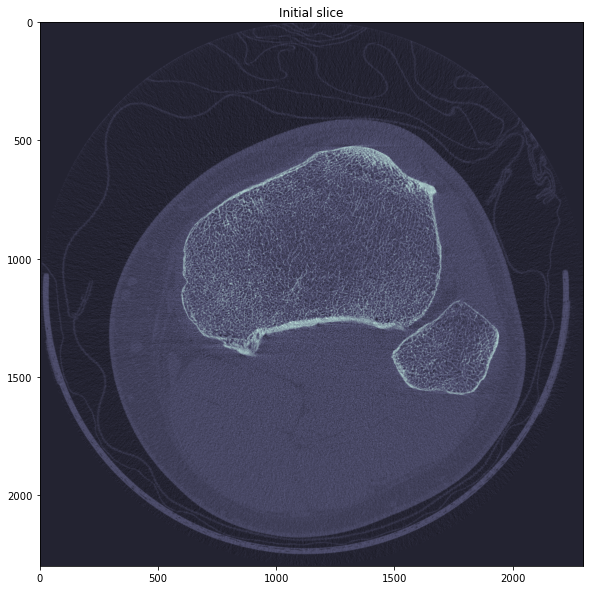

In [5]:
# Plot one slice of the image
image_array = sitk.GetArrayFromImage(img)

plt.figure(figsize=(10,10))
plt.imshow(image_array[3], cmap='bone')
plt.title('Initial slice')

In [6]:
# Extract a section of the image so everything runs faster
img_size = img.GetSize()
print(img_size)

#extract_filter = sitk.RegionOfInterestImageFilter()
#extract_filter.SetSize([s//2 for s in img_size]) # originally //3

#img = extract_filter.Execute(img)

(2300, 2300, 7)


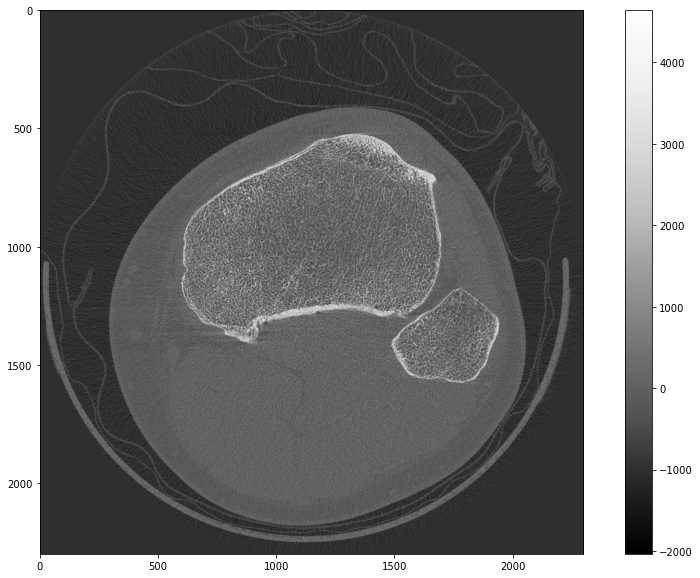

In [7]:
# Plot a slice of the section 
img_np = sitk.GetArrayFromImage(img)

slice_index = img_size[2]//3//2 # originally 168//3//2

plt.figure(figsize=(15,10))
plt.imshow(img_np[slice_index,:,:],cmap='Greys_r')
plt.colorbar()
plt.show()

## Periosteal mask

In [8]:
# Obtain periosteal mask
peri = autok.get_periosteal_mask(img)

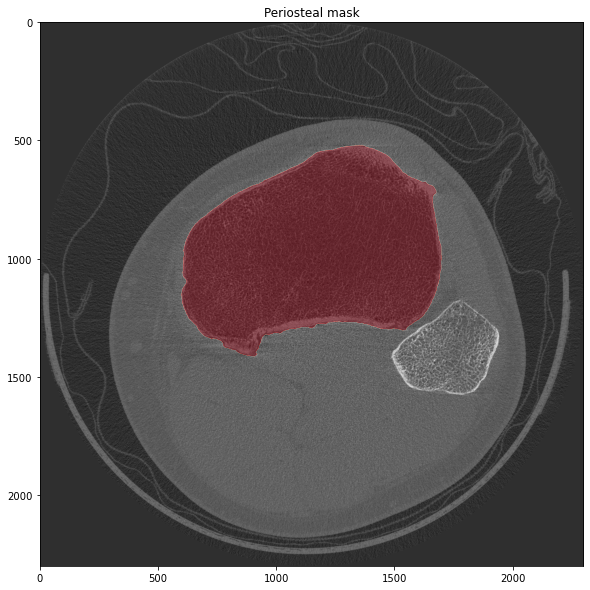

In [9]:
# Plot a slice of the image with the periosteal mask in red
peri_np = sitk.GetArrayFromImage(peri)>0

plt.figure(figsize=(15,10))
plt.imshow(img_np[slice_index],cmap='Greys_r')
plt.imshow(peri_np[slice_index],cmap='Reds',alpha=0.6*peri_np[slice_index])
plt.title('Periosteal mask')
plt.show()

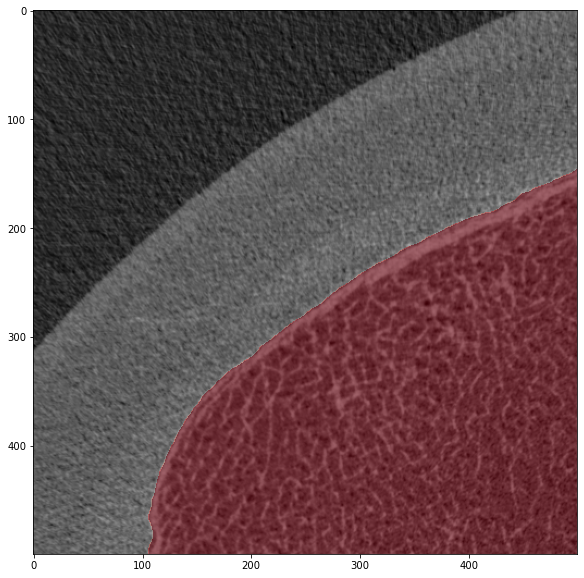

In [10]:
# Plot a slice of the image with the periosteal mask in red
peri_np = sitk.GetArrayFromImage(peri)>0

plt.figure(figsize=(15,10))
plt.imshow(img_np[slice_index,500:1000,500:1000],cmap='Greys_r')
plt.imshow(peri_np[slice_index,500:1000,500:1000],cmap='Reds',alpha=0.6*peri_np[slice_index,500:1000,500:1000])
plt.show()

## Endosteal mask

In [11]:
# Obtain endosteal mask (cortical and trabecular bone)
cort, trab = autok.get_endosteal_mask(img, peri)

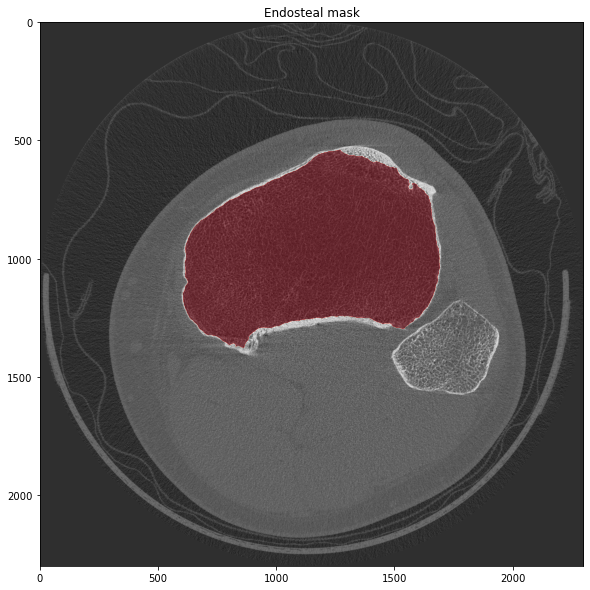

In [12]:
# Plot a slice of the image with the trabecular bone in red
trab_np = sitk.GetArrayFromImage(trab)>0

plt.figure(figsize=(15,10))
plt.imshow(img_np[slice_index],cmap='Greys_r')
plt.imshow(trab_np[slice_index],cmap='Reds',alpha=0.6*trab_np[slice_index])
plt.title('Endosteal mask')
plt.show()

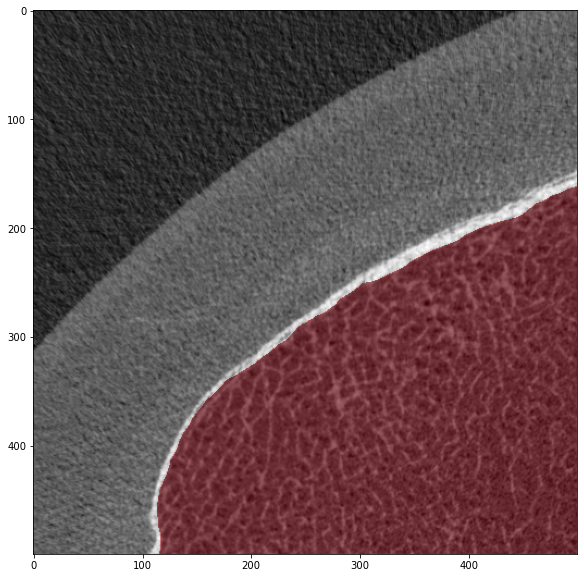

In [13]:
# Plot a slice of the image with the trabecular bone in red
trab_np = sitk.GetArrayFromImage(trab)>0

plt.figure(figsize=(15,10))
plt.imshow(img_np[slice_index,500:1000,500:1000],cmap='Greys_r')
plt.imshow(trab_np[slice_index,500:1000,500:1000],cmap='Reds',alpha=0.6*trab_np[slice_index,500:1000,500:1000])
plt.show()

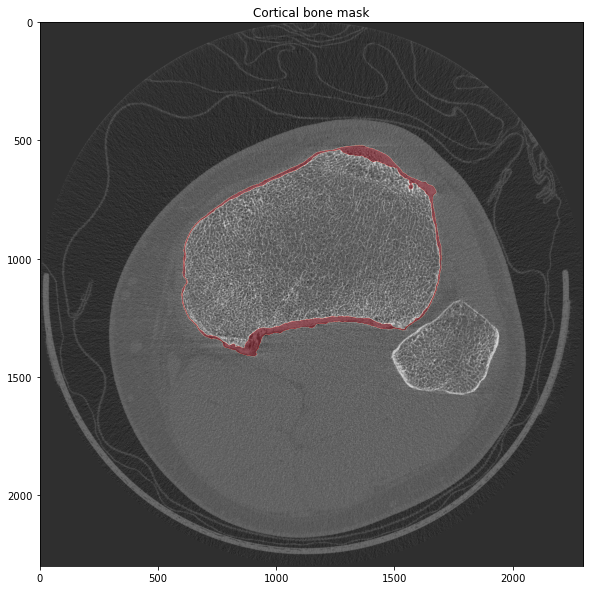

In [14]:
# Plot a slice of the image with the cortical bone in red
cort_np = sitk.GetArrayFromImage(cort)>0

plt.figure(figsize=(15,10))
plt.imshow(img_np[slice_index],cmap='Greys_r')
plt.imshow(cort_np[slice_index],cmap='Reds',alpha=0.6*cort_np[slice_index])
plt.title('Cortical bone mask')
plt.show()

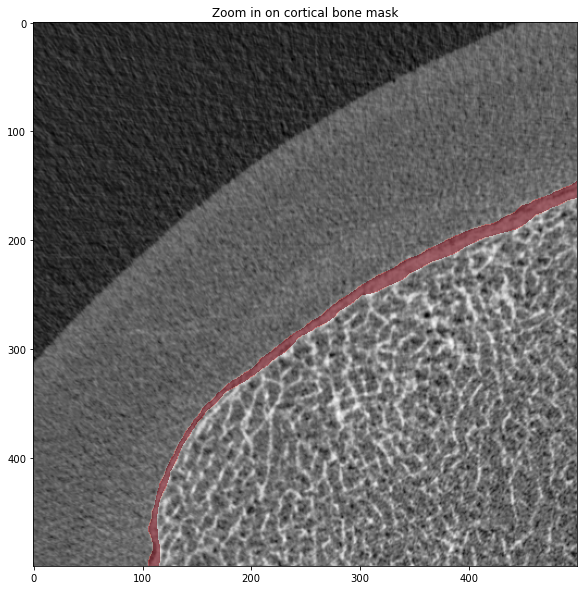

In [15]:
# Plot a slice of the image with the cortical bone in red
cort_np = sitk.GetArrayFromImage(cort)>0

plt.figure(figsize=(15,10))
plt.imshow(img_np[slice_index,500:1000,500:1000],cmap='Greys_r')
plt.imshow(cort_np[slice_index,500:1000,500:1000],cmap='Reds',alpha=0.6*cort_np[slice_index,500:1000,500:1000])
plt.title('Zoom in on cortical bone mask')
plt.show()

## Laplace Hamming Filter

In [16]:
from skimage.filters import laplace
img = img_np # make sure it is a square

r = 5 # kernel size
ham = np.hamming(img.shape[1])[:,None] # 1D hamming - size must be length or width of img
ham2d = np.sqrt(np.dot(ham, ham.T)) ** r # expand to 2D hamming

In [17]:
dft = sitk.ForwardFFTImageFilter()
img_f = dft.Execute(sitk.GetImageFromArray(img))
f = sitk.GetArrayFromImage(img_f)

In [19]:
f_shifted = np.fft.fftshift(f)
f_complex = f_shifted[0,:,:]*1j + f_shifted[1,:,:]
f_filtered = ham2d * f_complex

In [20]:
f_filtered_shifted = np.fft.fftshift(f_filtered)
inv_img = np.fft.ifft2(f_filtered_shifted) # inverse F.T.
filtered_img = np.abs(inv_img)
filtered_img -= filtered_img.min()
filtered_img = filtered_img*255 / filtered_img.max()
filtered_img = filtered_img.astype(np.uint8)

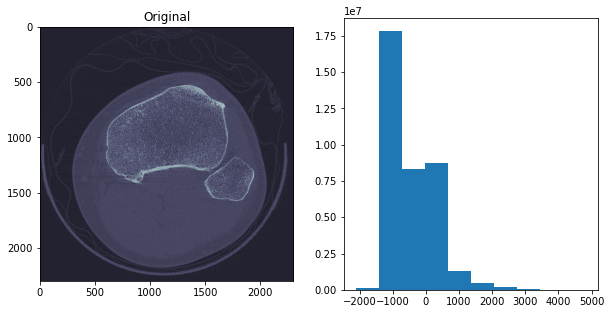

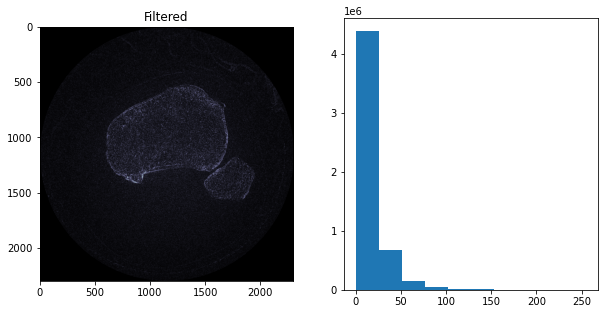

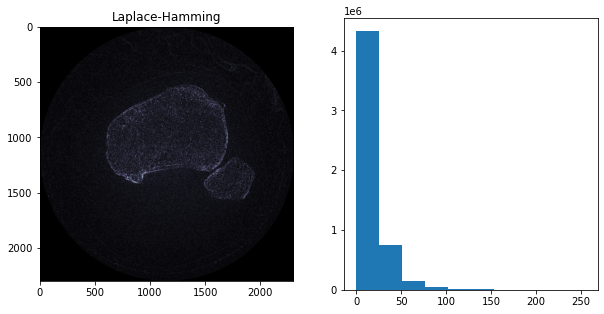

In [21]:
fig, ax = plt.subplots (1, 2, figsize=(10,5))
ax[0].set_title('Original')
ax[0].imshow(img[6], cmap='bone')
ax[1].hist(img.ravel())
plt.show()

fig, ax = plt.subplots (1, 2, figsize=(10,5))
ax[0].set_title('Filtered')
ax[0].imshow(filtered_img, cmap='bone')
ax[1].hist(filtered_img.ravel())
plt.show()

Lfilt_ski = laplace(filtered_img)
img_np_filt = filtered_img+Lfilt_ski

fig, ax = plt.subplots (1, 2, figsize=(10,5))
ax[0].set_title('Laplace-Hamming')
ax[0].imshow(img_np_filt, cmap='bone')
ax[1].hist(img_np_filt.ravel())
plt.show()

## ROI masks

In [22]:
# Apply masks to input image
trab_ROI = trab_np * img_np_filt
cort_ROI = cort_np * img_np_filt
peri_ROI = peri_np * img_np_filt

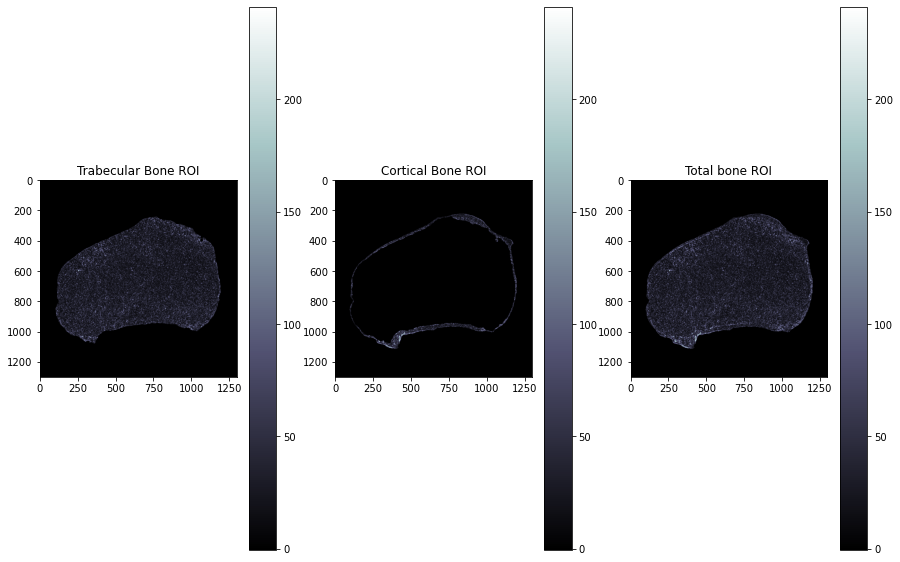

In [23]:
# Plot ROI
_min, _max = np.amin([trab_ROI,cort_ROI]), np.amax([trab_ROI,cort_ROI]) # Get min and max pixel values to plot on same scale

fig, ax = plt.subplots (1, 3, figsize=(15,10))
im = ax[0].imshow(trab_ROI[slice_index,300:1600,500:1800], cmap='bone', vmin = _min, vmax = _max)
ax[0].set_title('Trabecular Bone ROI')
ax[0].autoscale(False)
plt.colorbar(im, ax = ax[0])

im = ax[1].imshow(cort_ROI[slice_index,300:1600,500:1800], cmap='bone', vmin = _min, vmax = _max)
ax[1].set_title('Cortical Bone ROI')
ax[1].autoscale(False)
plt.colorbar(im, ax = ax[1])

im = ax[2].imshow(peri_ROI[slice_index,300:1600,500:1800], cmap='bone', vmin = _min, vmax = _max)
ax[2].set_title('Total bone ROI')
ax[2].autoscale(False)
plt.colorbar(im, ax = ax[2])

# ITSA

In [24]:
# Due to the calculations in ITSA, the minimum intensity must be 0, 
# hence the minimum intensity value will be added to all pixels
ROI_adj = trab_ROI - np.nanmin(trab_ROI)

# Delete background (highest peak in histogram)
vals, cts = np.unique(ROI_adj, return_counts=True)
maxval = vals[np.argmax(cts)]
ROI_nb = np.where(ROI_adj!=maxval, ROI_adj, np.nan)

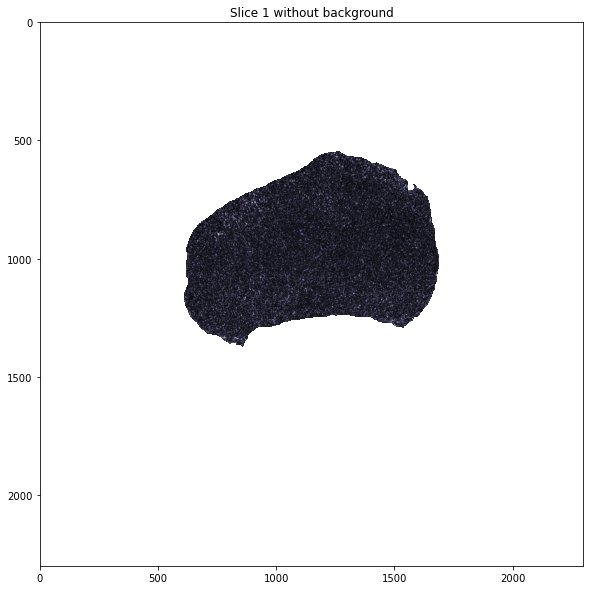

In [25]:
# Plot slice without background
plt.figure(figsize=(15,10))
plt.imshow(ROI_nb[slice_index], cmap='bone')
plt.title('Slice %i without background' %slice_index);

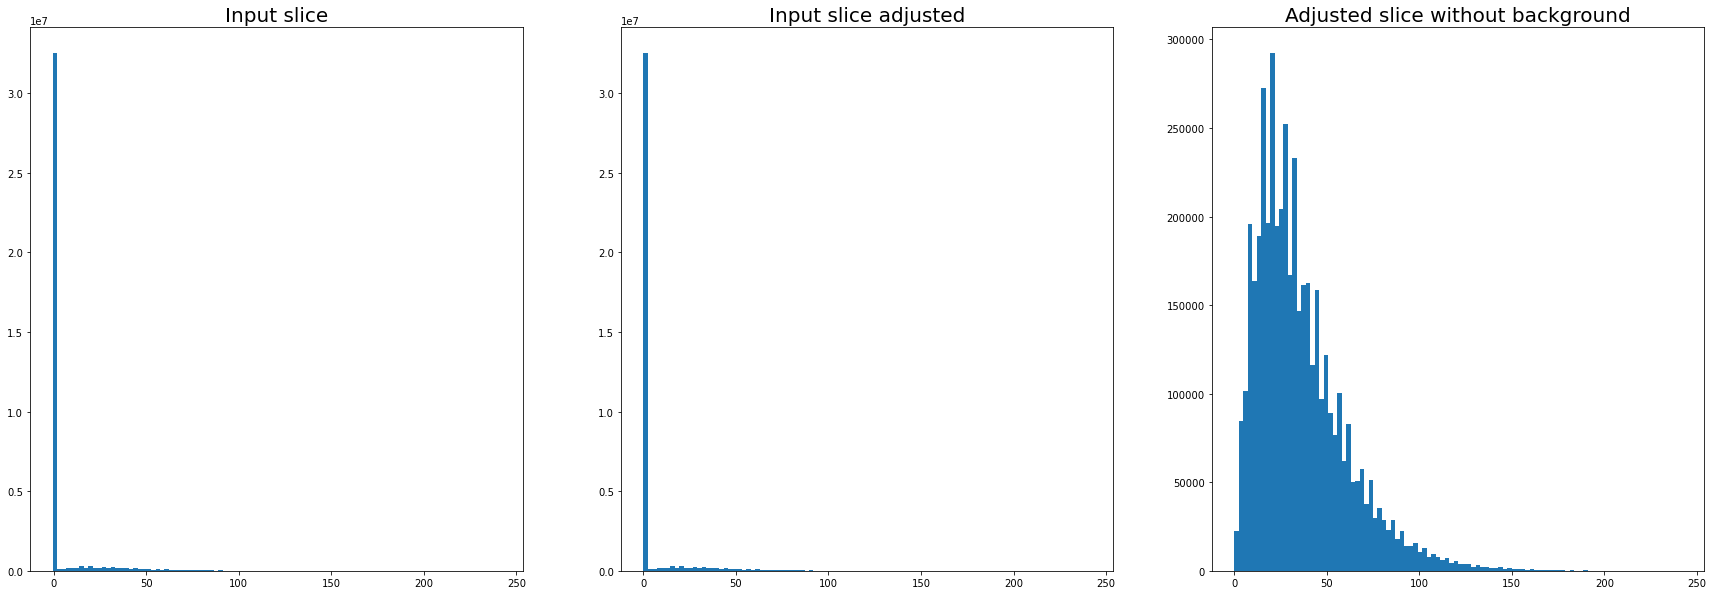

In [26]:
# Compare histograms
fig, ax = plt.subplots (1, 3, figsize=(30,10))
ax[0].hist(trab_ROI.ravel(), bins=100);
ax[0].set_title('Input slice').set_fontsize(20);
ax[1].hist(ROI_adj.ravel(), bins=100);
ax[1].set_title('Input slice adjusted').set_fontsize(20);
ax[2].hist(ROI_nb.ravel(), bins=100);
ax[2].set_title('Adjusted slice without background').set_fontsize(20);

## Initial Otsu threshold values

In [27]:
ROI_nmask = np.ma.masked_invalid(ROI_nb)
thresholds = threshold_multiotsu(ROI_nmask.compressed(), classes=4)
print(thresholds)

th1 = thresholds[1]
print(th1)

th_img = label(ROI_nmask > th1).astype(bool)

[25.03657322 48.65598192 82.66793045]
48.65598192401961


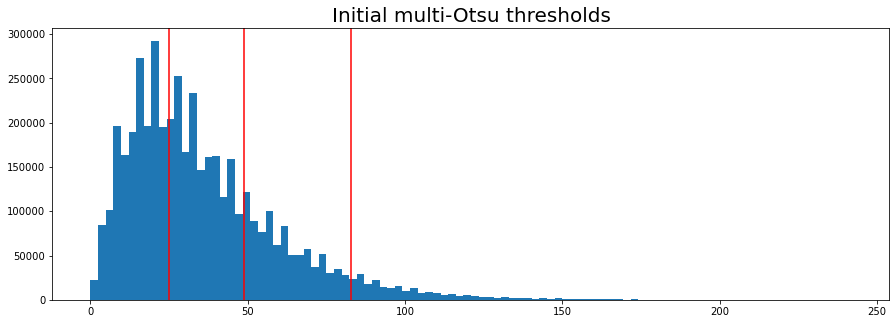

In [28]:
# Histogram
plt.figure (figsize=(15,5))
plt.hist(ROI_nb.ravel(), bins=100)
for t in range(len(thresholds)):
    plt.axvline(thresholds[t], color='r')
plt.title('Initial multi-Otsu thresholds').set_fontsize(20);

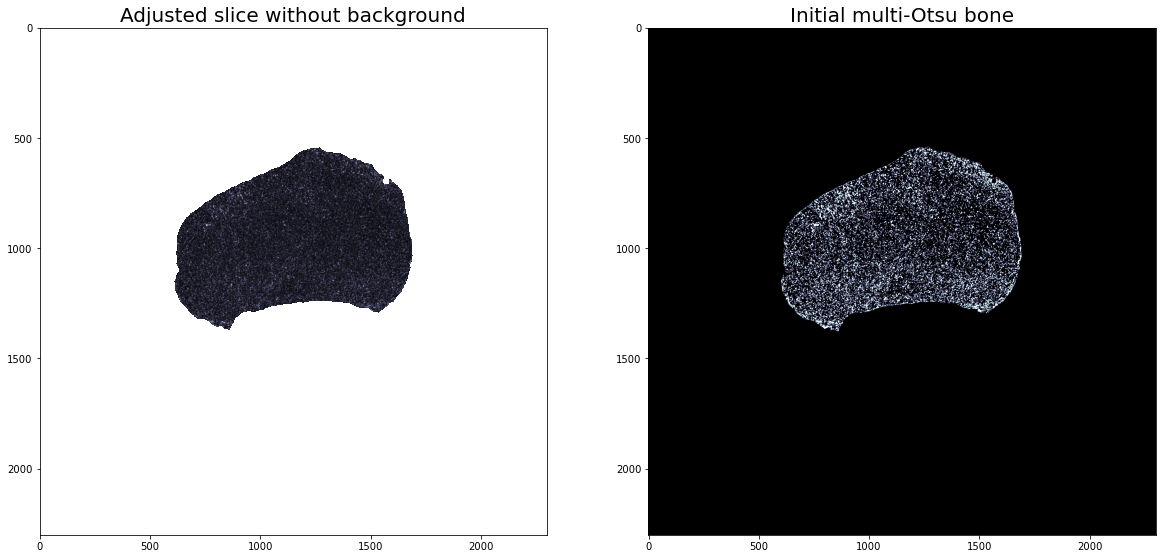

In [29]:
# Plot resulting image
fig, ax = plt.subplots (1, 2, figsize=(20,10))
ax[0].imshow(ROI_nb[slice_index], 'bone')
ax[0].set_title('Adjusted slice without background').set_fontsize(20);
ax[1].imshow(th_img[slice_index], 'bone')
ax[1].set_title('Initial multi-Otsu bone').set_fontsize(20);

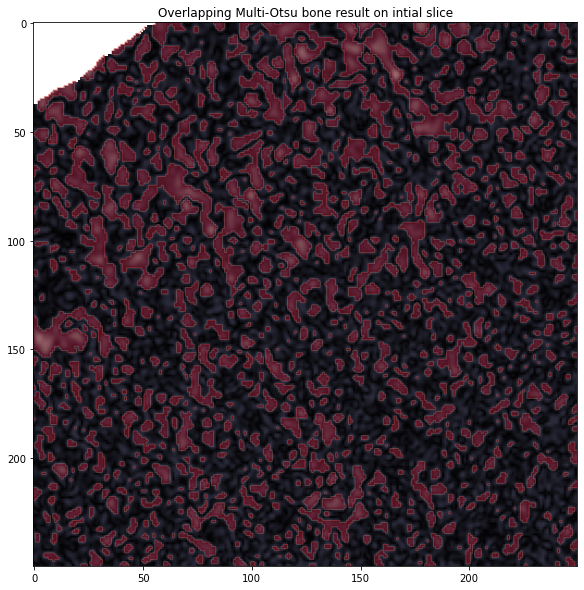

In [30]:
# Overlapping multi-Otsu result to image
plt.figure(figsize=(15,10))
plt.imshow(ROI_nb[slice_index,750:1000,750:1000], cmap='bone')
plt.imshow(th_img[slice_index,750:1000,750:1000], cmap='Reds', alpha=0.6*th_img[slice_index,750:1000,750:1000])
plt.title('Overlapping Multi-Otsu bone result on intial slice')
plt.show()

### ITSA threshold

In [31]:
def optimize_thresh(roi, threshold, view_plots):
    # Optimize threshold to separate marrow and bone
    k = 1
    
    ThPrev = 0 #previous
    ThRev = threshold #revised

    roi_im = sitk.GetImageFromArray(roi) ## change array into sitk image

    while ThRev!=ThPrev: #while new threshold is NOT equal to prev threshold
        
        ThPrev = ThRev #update the previous threshold for comparison in subsequent iterations
        
        kneetrb0 = label(roi > ThRev).astype(bool)
        
        kneetrbmask_rso = (morphology.remove_small_objects(kneetrb0, min_size=5, connectivity=1)).astype(int) 
        
        kneetrbmask_n = cv2.normalize(src=kneetrbmask_rso, dst=None, alpha=0.0, beta=255.0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        
        kneetrbmask_ni = sitk.GetImageFromArray(kneetrbmask_n) ## change array into image
        kneetrbmask_not = sitk.BinaryThreshold(kneetrbmask_ni, 0, 1) ## separate bone/background, background=1, bone=0
        kneetrbmask = sitk.Not(kneetrbmask_not)  
        kneetrbseg1 = sitk.Mask(roi_im, kneetrbmask) ## mask 
        
        #premarrow = roi - kneetrbseg1  #original ROI - bone = marrow
        roi_im64 = sitk.Cast(roi_im,sitk.sitkUInt64) ## Convert images from 64 bit floats to 64 bit ints
        kneetrbseg164 = sitk.Cast(kneetrbseg1,sitk.sitkUInt64) 
        premarrow = roi_im64 - kneetrbseg164

        premarrow0 = sitk.GetArrayFromImage(premarrow) ## Convert images to numpy arrays for masking
        kneetrbseg0 = sitk.GetArrayFromImage(kneetrbseg164)

        # Mask the 0's in the image to exclude in the mean calculations
        marrowsegp = np.ma.masked_where(premarrow0 == 0, premarrow0)
        bonesegp = np.ma.masked_where(kneetrbseg0 == 0, kneetrbseg0) 

        # Calculate mean signal intensities of marrow and bone
        marrowsegI = np.mean(marrowsegp)
        bonesegI = np.mean(bonesegp)

        # Threshold optimization equation
        ThRev = (1+((bonesegI-marrowsegI)/bonesegI))*marrowsegI 
        
        fig, axs = plt.subplots (1,2, figsize=(20,10))  
        axs[0].imshow(premarrow0[slice_index], cmap='bone') 
        axs[0].set_title('Marrow')
        axs[1].imshow(kneetrbseg0[slice_index], cmap='bone') 
        axs[1].set_title('Bone')
        plt.show()

        print(f"Revised Threshold={ThRev}\n\tMean marrow intensity={marrowsegI} pixels\n\tMean bone intensity={bonesegI} pixels\n\n")
        
        k+=1
        if k==50:
            break
        
    return ThRev, kneetrbseg1

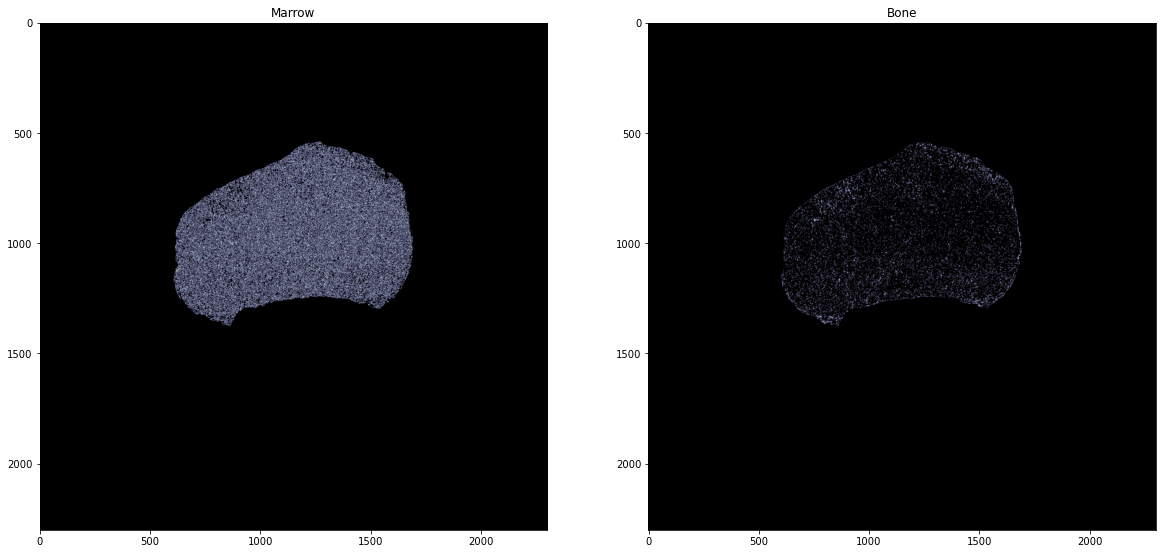

Revised Threshold=39.948285956993196
	Mean marrow intensity=24.152778624307864 pixels
	Mean bone intensity=69.80229490211595 pixels




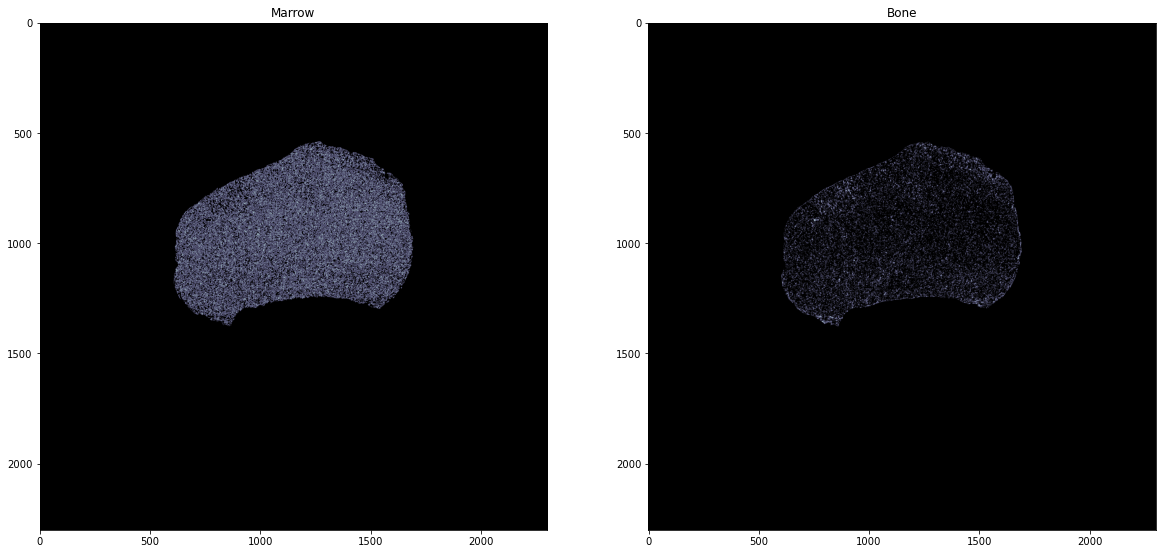

Revised Threshold=35.35236602918484
	Mean marrow intensity=21.323571552958153 pixels
	Mean bone intensity=62.33154200482562 pixels




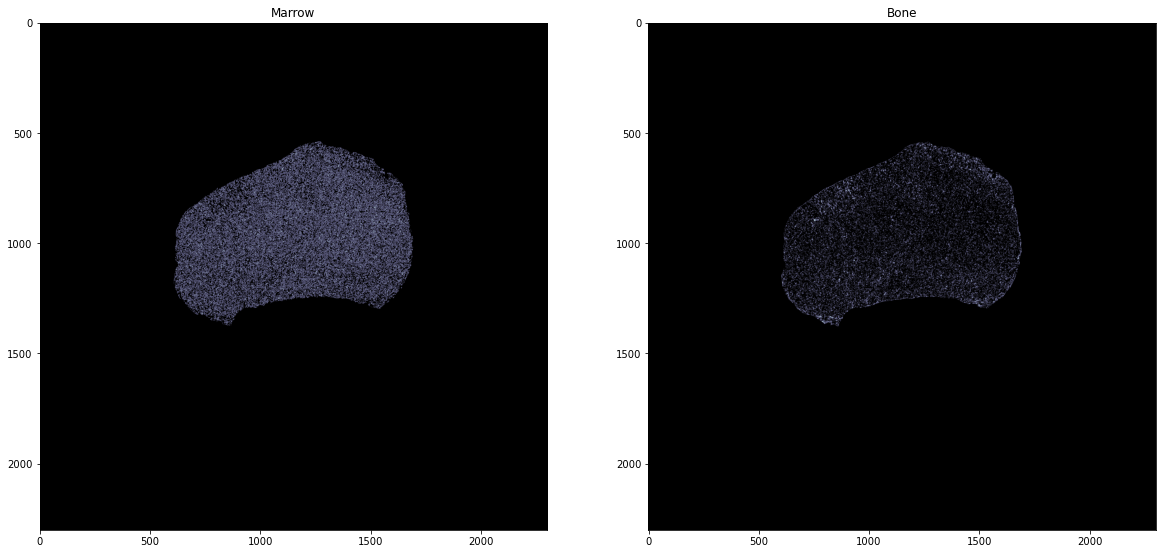

Revised Threshold=32.21660677064526
	Mean marrow intensity=19.344226872506194 pixels
	Mean bone intensity=57.81952428372778 pixels




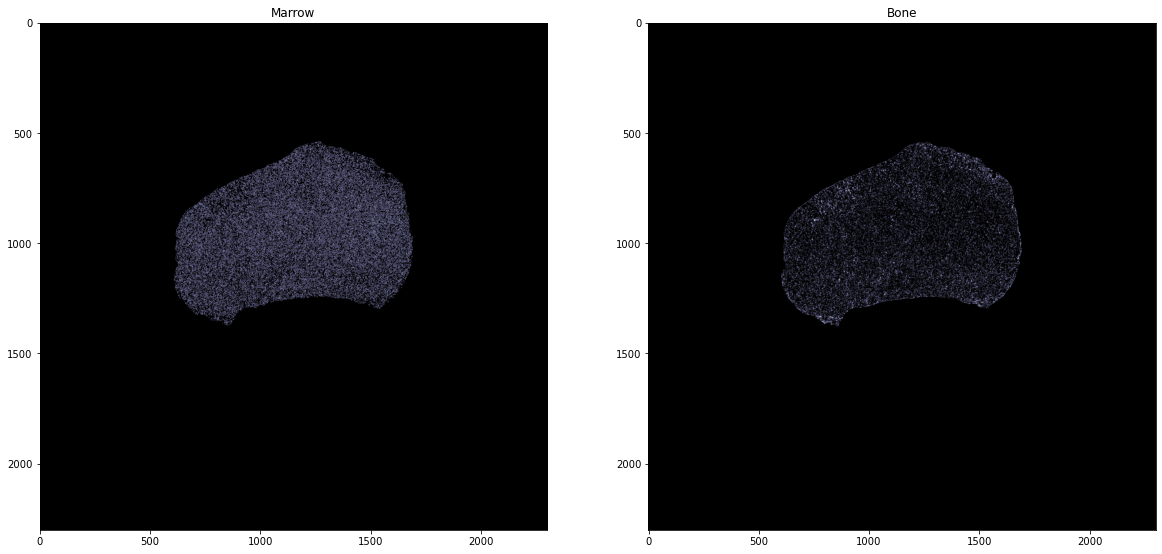

Revised Threshold=30.201379311330147
	Mean marrow intensity=18.057220535615457 pixels
	Mean bone intensity=55.142872966935585 pixels




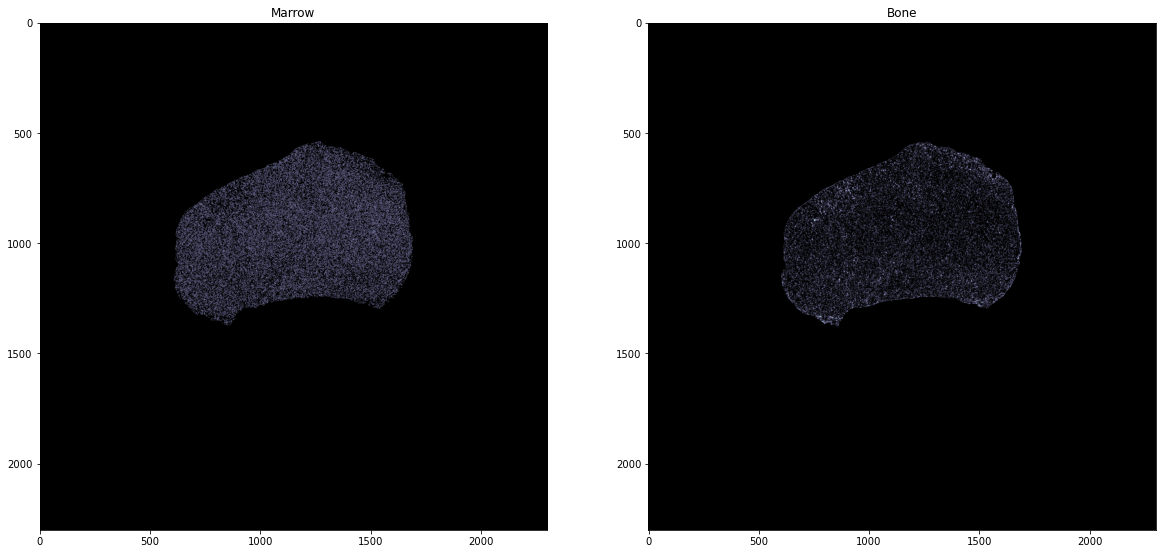

Revised Threshold=28.803079445129086
	Mean marrow intensity=17.159389986580557 pixels
	Mean bone intensity=53.38300424671848 pixels




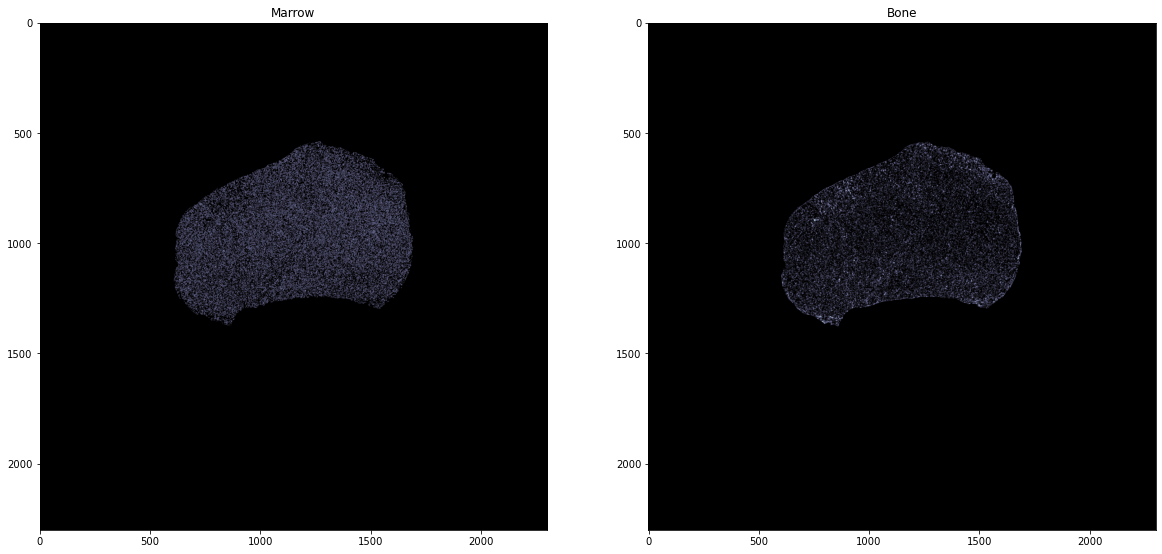

Revised Threshold=28.073137458729924
	Mean marrow intensity=16.68964256664325 pixels
	Mean bone intensity=52.49461305759598 pixels




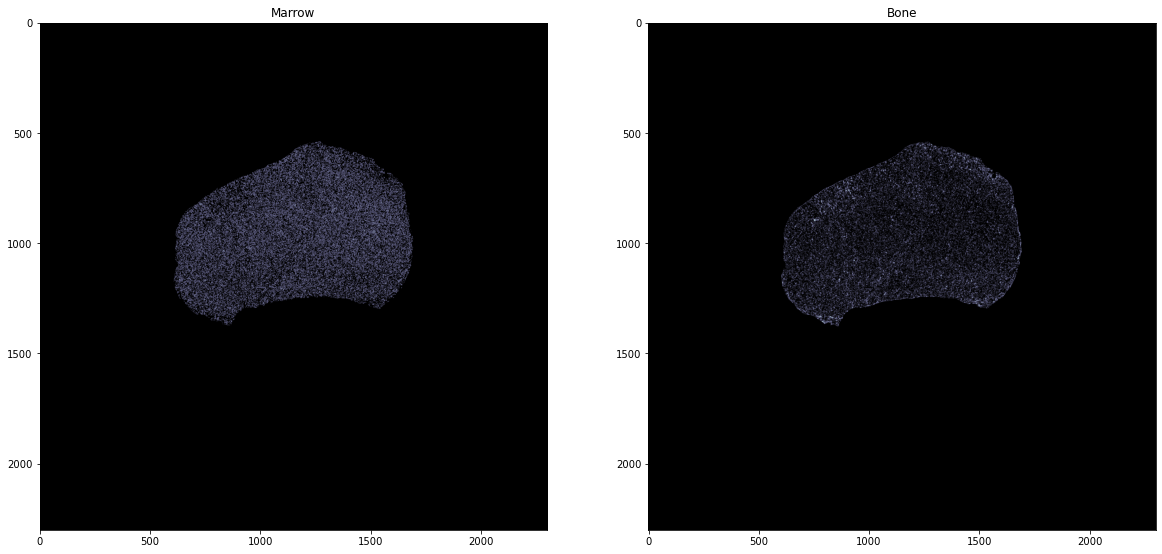

Revised Threshold=27.34879475216563
	Mean marrow intensity=16.222807454874793 pixels
	Mean bone intensity=51.63601492321362 pixels




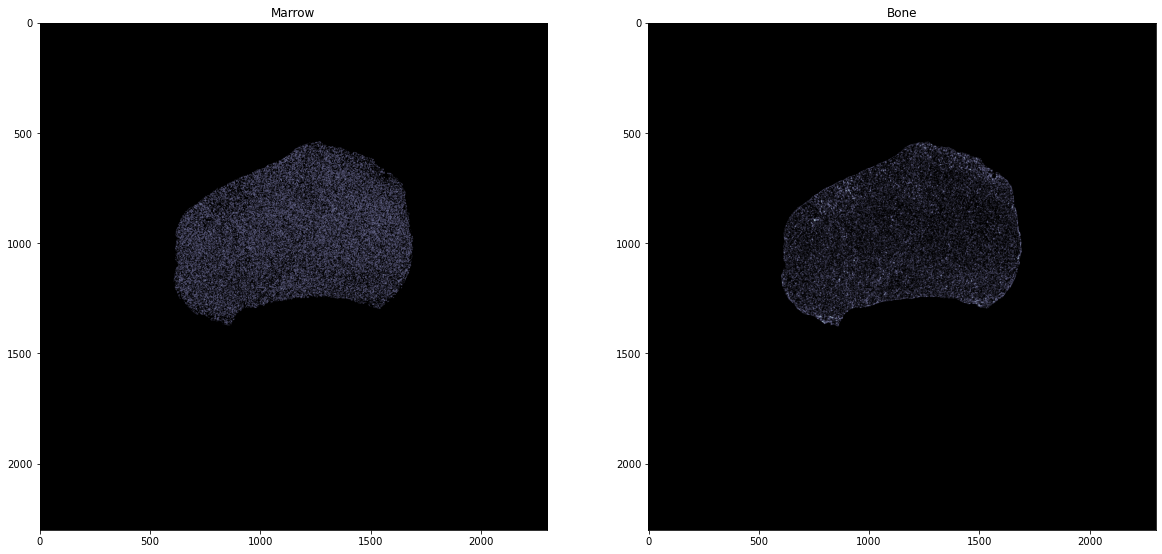

Revised Threshold=26.604371235087168
	Mean marrow intensity=15.742678752838195 pixels
	Mean bone intensity=50.77497058502181 pixels




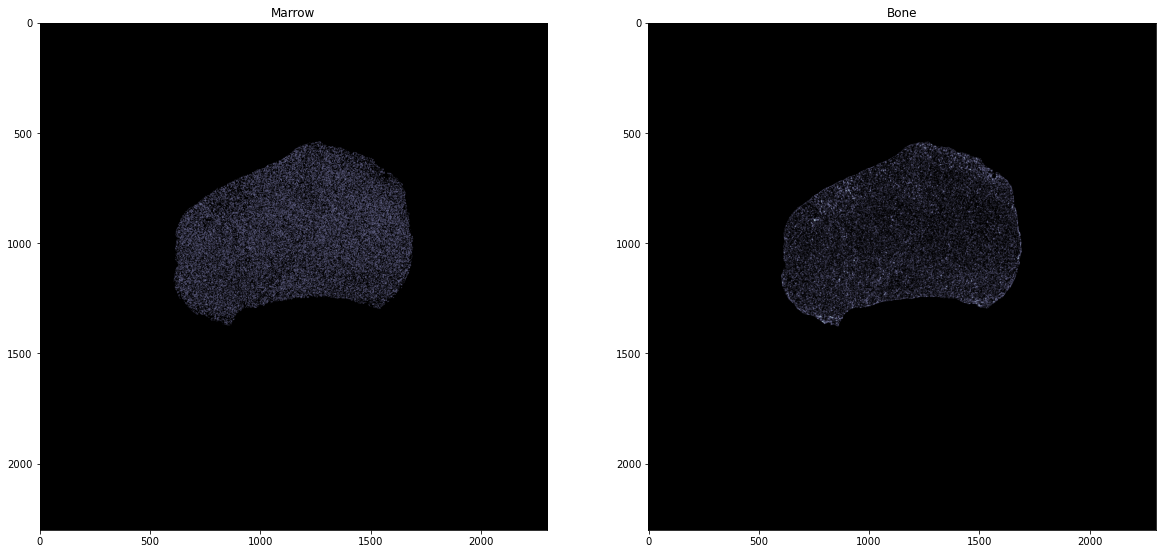

Revised Threshold=25.968997342110676
	Mean marrow intensity=15.333186096754819 pixels
	Mean bone intensity=50.05063536875204 pixels




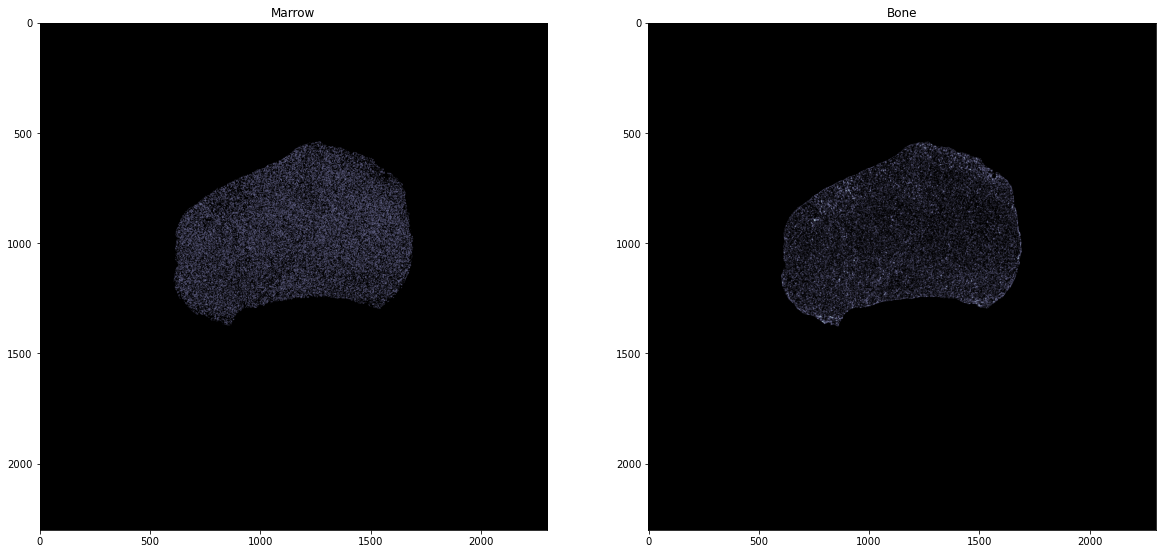

Revised Threshold=25.836726066309144
	Mean marrow intensity=15.247320649925834 pixels
	Mean bone intensity=49.91090978374121 pixels




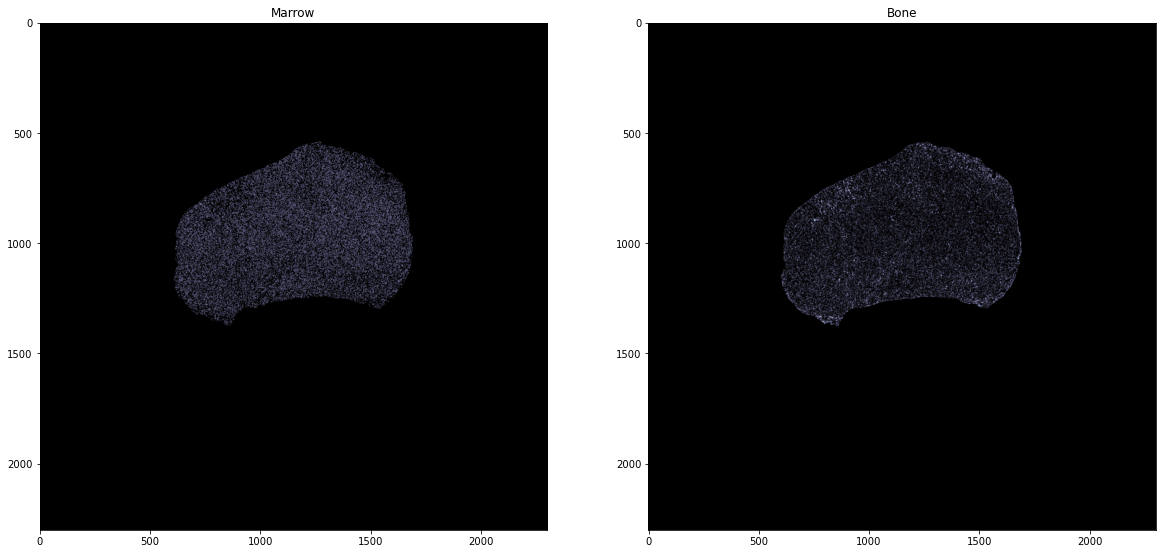

Revised Threshold=25.835771249701125
	Mean marrow intensity=15.246709063276624 pixels
	Mean bone intensity=49.909781356656104 pixels




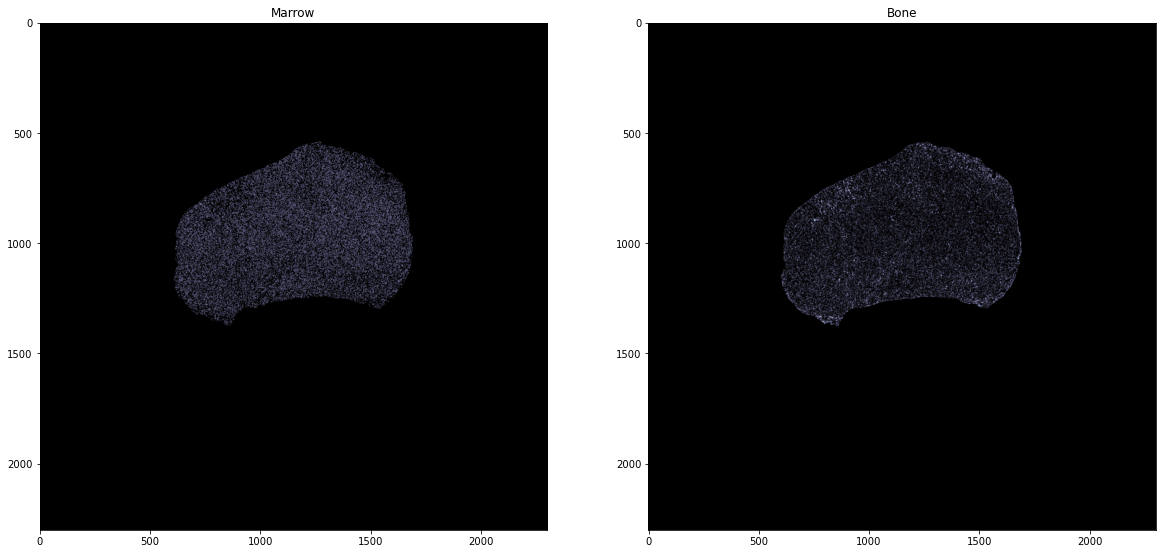

Revised Threshold=25.835771249701125
	Mean marrow intensity=15.246709063276624 pixels
	Mean bone intensity=49.909781356656104 pixels




In [32]:
ITSA_th, ITSA_im = optimize_thresh(ROI_nb, th1, 'on')
ITSA_n = sitk.GetArrayFromImage(ITSA_im)

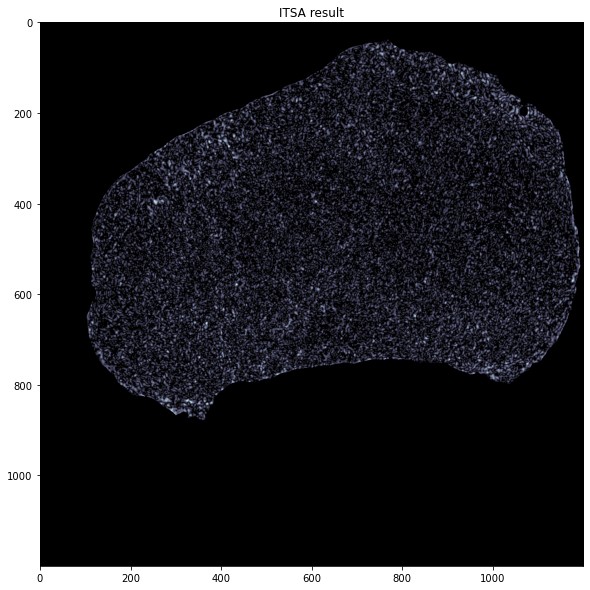

In [33]:
# ITSA result image
plt.figure(figsize=(15,10))
plt.imshow(ITSA_n[slice_index, 500:1700, 500:1700], cmap='bone')
plt.title('ITSA result')
plt.show()

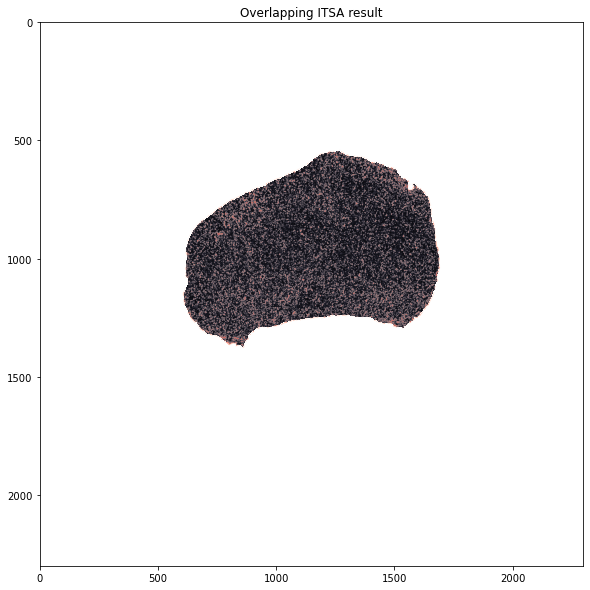

In [34]:
# Overlapping ITSA result to image
plt.figure(figsize=(15,10))
plt.imshow(ROI_nb[slice_index], cmap='bone')
plt.imshow(ITSA_n[slice_index], cmap='Reds', alpha=0.6*th_img[slice_index]) 
plt.title('Overlapping ITSA result')
plt.show()

#### Compare initial Otsu threshold to ITSA

In [35]:
print('Otsu threshold: ', th1)
print('ITSA threshold: ', ITSA_th)

Otsu threshold:  48.65598192401961
ITSA threshold:  25.835771249701125


Text(0.5, 1.0, 'ITSA bone result')

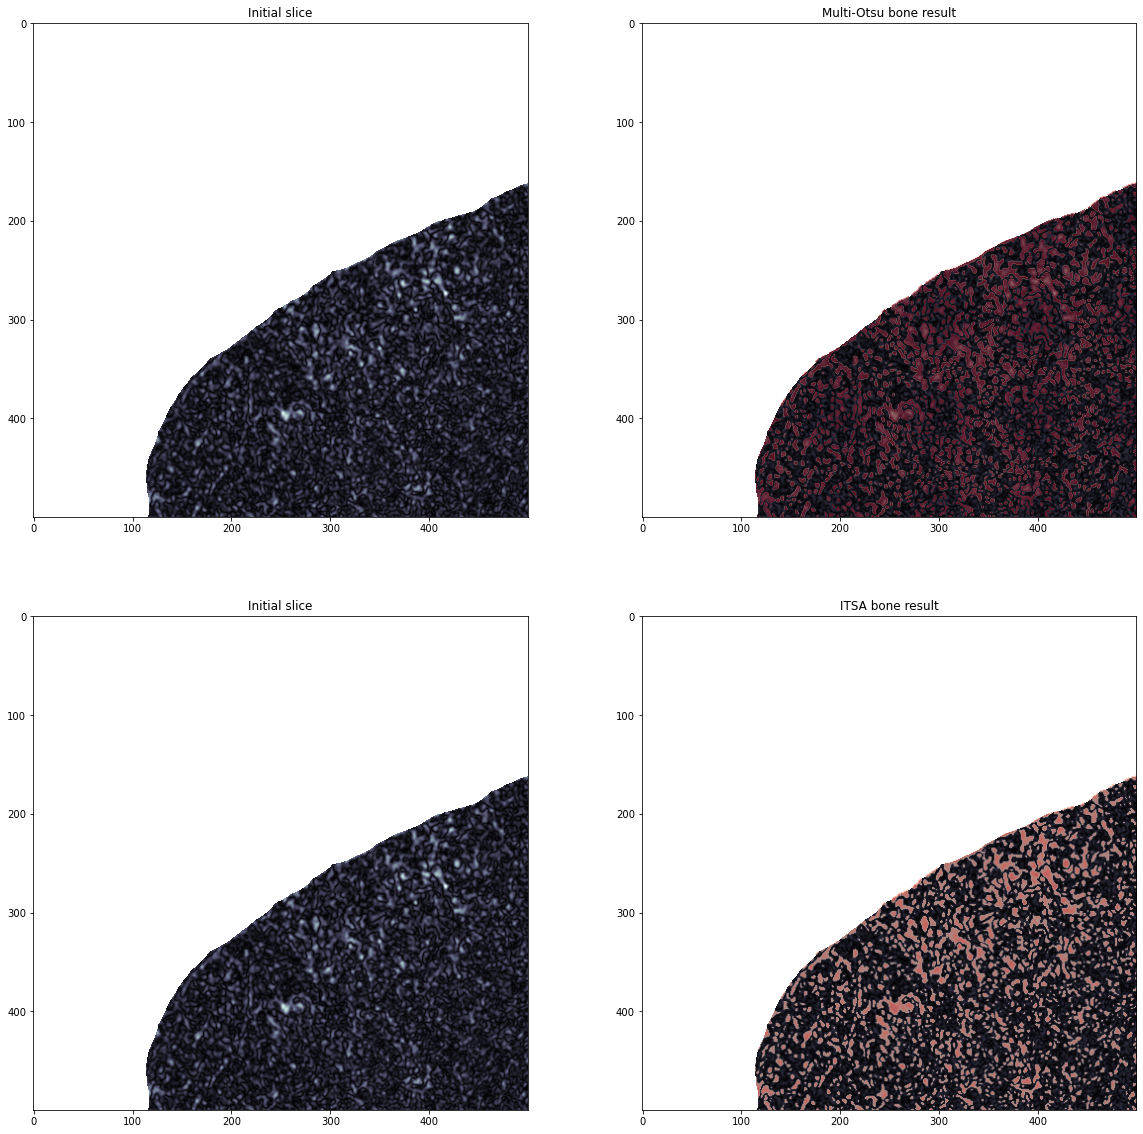

In [36]:
fig, axs = plt.subplots (2,2, figsize=(20,20))  
axs[0,0].imshow(ROI_nb[slice_index, 500:1000, 500:1000], cmap='bone')
axs[0,0].set_title('Initial slice')

axs[0,1].imshow(ROI_nb[slice_index, 500:1000, 500:1000], cmap='bone')
axs[0,1].imshow(th_img[slice_index, 500:1000, 500:1000], cmap='Reds', alpha=0.6*th_img[slice_index, 500:1000, 500:1000])
axs[0,1].set_title('Multi-Otsu bone result')

axs[1,0].imshow(ROI_nb[slice_index, 500:1000, 500:1000], cmap='bone')
axs[1,0].set_title('Initial slice')

axs[1,1].imshow(ROI_nb[slice_index, 500:1000, 500:1000], cmap='bone')
axs[1,1].imshow(ITSA_n[slice_index, 500:1000, 500:1000], cmap='Reds', alpha=0.6*th_img[slice_index, 500:1000, 500:1000])
axs[1,1].set_title('ITSA bone result')

## Calculations

In [ ]:
# Calculate periosteal circumference
def get_peri_circ(image):
    peri_c = 0

    for l in range(len(image)):
        # Change slice into compatible format for findContours function
        peri_np8 = (image[l]*1).astype(np.uint8) 
        contours, hierarchy = cv2.findContours(peri_np8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        blank = np.zeros(peri_np8.shape, np.uint8) 

        # Find largest contour per slice
        areas = [cv2.contourArea(c) for c in contours] 
        max_index = np.argmax(areas)
        cnt = contours[max_index]

        # Plot contour
        #plt.imshow(cv2.drawContours(blank, cnt, -1, (255, 0, 0), 3),cmap='bone')
        #plt.title('Periosteal perimeter')
        #plt.show()

        # Calculate periosteal perimeter per slice and total
        peri_cl = cv2.arcLength(cnt,True)
        peri_c = peri_c + peri_cl
    return peri_c

In [ ]:
trab_ROI = ITSA_n

In [ ]:
### Total bone parameters *voxelsize (product of dimensions (image get size))
# Bone volume
### peri or trab>otsu (0, 1)
BV = np.sum(peri_ROI)

# Total volume
### peri mask
TV = np.sum(peri_np)

# Bone volume fraction
BVF = BV/TV

### Trabecular bone parameters
# Trabecular mass
Tb_N = np.sum(trab_ROI)

# Trabecular density
# Trabecular tissue mineral density (trabecular TMD)
###### mass of bone/volume of only bone

# Trabecular thickness
Tb_Th = (BV/TV)/Tb_N #200um

# Trabecular separation
Tb_Sp = (1-BV/TV)/Tb_N

## Cortical bone parameters
# Cortical thickness
####### sum of pixels / average circ
#### trab = 1/10 cortical values ish
peri_circ = get_peri_circ(peri_np)
Ct_Th = np.mean(cort_ROI)/peri_circ

### Derived equations

In [ ]:
# Bone volume fraction
AB = BV # If BV/TV = AB/AT, then
AT = TV 

# Mean trabecular thickness
PB = (2*AB)/Tb_Th # If Tb.Th = 2 AB/PB, then

# Bone surface fraction
BS = TV*PB/AT # If BS/TV = PB/AT, then
BSF = PB/AT

### Summary table

In [ ]:
print(tabulate([['Bone volume','BV', 'Sum of bone', BV],
                ['Total volume','TV', 'Sum of all', TV],
                ['Bone volume fraction', 'BV/TV', 'BV/TV', BVF],
                ['Trabecular mass', 'Tb.N', 'Sum of trabecular bone', Tb_N],
                ['Trabecular thickness', 'Tb.Th', 'Tb.Th = (BV/TV)/Tb.N', Tb_Th],
                ['Trabecular separation', 'Tb.Sp', 'Tb.Sp = (1 – BV/TV)/Tb.N', Tb_Sp],
                ['Cortical thickness', 'Ct.Th', 'Ct.Th = Mean cort. area/Peri. circum.', Ct_Th],
                ['--- DERIVED EQUATIONS', '', '', ''],
                ['Bone volume fraction', 'BV/TV', 'BV/TV = AB/AT', BVF], 
                ['Total bone area', 'AB', 'BV/TV = AB/AT', AB],
                ['Total mask area \n  with bone and marrow', 'AT', 'BV/TV = AB/AT'  , AT],
                ['Total perimeter \n  along bone contour'  , 'PB', 'Tb.Th = 2AB/PB', PB],
                ['Bone surface', 'BS', 'BS/TV = PB/AT', BS],
                ['Bone surface fraction', 'BS/TV', 'BS/TV = PB/AT', BSF]],
                headers=['Parameter', 'Abbreviation', 'Equation', 'Value']))

# Notes
SITK pixel types http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/03_Image_Details.html

SITK documentation https://readthedocs.org/projects/simpleitk/downloads/pdf/release/

SITK liver segmentation example https://notebook.community/jon-young/medicalimage/Liver%20Interactive

SITK Hamming filter https://simpleitk.org/SimpleITK-Notebooks/20_Expand_With_Interpolators.html

Laplace Hamming https://github.com/guillaume-chevalier/filtering-stft-and-laplace-transform


In [ ]:
# If applying filter to more than one image:
# lap = sitk.LaplacianImageFilter()
# img_lap = lap.Execute(img_np), else in line